# Adquisicion, limpieza y manejo de los datos

#### Importante: Si no deseas replicar la parte de adquisicion de los datos mediante web scraping, sigue las notas indicadas al principio de cada apartado del notebook

# Importar librerias

In [2]:
from bs4 import BeautifulSoup as BS
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from datetime import datetime


pd.options.display.max_rows = None
pd.options.display.max_columns = None

#### Resumen Web Scraping
* Se extraen por separado las estadisitcas intrinsecas de los peleadores y el listado de las peleas y eventos de UFC
* Posteriormente se unirán para usar las estadisticas de los peleadroes para predecir el resultado

#### Descripcion de las variables que se obtiene del webscraping
SLpM - Significant Strikes Landed per Minute 

Str. Acc. - Significant Striking Accuracy 

SApM - Significant Strikes Absorbed per Minute

Str. Def. - Significant Strike Defence (the % of opponents strikes that did not land)

TD Avg. - Average Takedowns Landed per 15 minutes

TD Acc. - Takedown Accuracy

TD Def. - Takedown Defense (the % of opponents TD attempts that did not land)

Sub. Avg. - Average Submissions Attempted per 15 minutes 

# 1. Scraping Fighters
#### Si quieres usar el dataset proporcionado en el link de la memoria pasad al apartado 1.1

* Scraping pagina estadisticas peleadores ufc: http://ufcstats.com/statistics/fighters

In [111]:
# guardamos una lista de caracteres para poder variar la página de la web de la UFC

abecedario = string.ascii_lowercase
fighters_df_list = []
for letra in abecedario:
    fighter_letra_link = f'http://ufcstats.com/statistics/fighters?char={letra}&page=all'
    
    #Obtenemos la tabla de peleadores cuyo nombre empieza por la letra
    df_fighters = pd.read_html(fighter_letra_link)[0]
    df_fighters.dropna(how = 'all', axis = 0, inplace = True)
    df_fighters.reset_index(drop=True, inplace = True)
    
    #Agregamos los enlaces a la pagina de cada peleador para obtener 
    #posteriormente sus estadisticas estaticas
    response = requests.get(fighter_letra_link)
    soup = BS(response.text)
    enlaces = []
    for tr in soup.find_all('tr')[2:]:
        enlace = tr.find('a')['href']
        enlaces.append(enlace)
    df_fighters['enlaces'] = pd.Series(enlaces)

    fighters_df_list.append(df_fighters)

peleadores = pd.concat(fighters_df_list)
peleadores.shape

(4033, 12)

In [112]:
peleadores.head()

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt,enlaces
0,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/93fe7332d1...
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4.0,6.0,0.0,NaN,http://ufcstats.com/fighter-details/15df64c02b...
2,Nariman,Abbasov,Bayraktar,"5' 8""",155 lbs.,"66.0""",Orthodox,28.0,4.0,0.0,NaN,http://ufcstats.com/fighter-details/59a9d6dac6...
3,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10.0,15.0,0.0,NaN,http://ufcstats.com/fighter-details/b361180739...
4,Hamdy,Abdelwahab,The Hammer,"6' 2""",264 lbs.,"72.0""",Southpaw,5.0,0.0,0.0,NaN,http://ufcstats.com/fighter-details/3329d692ae...


* Scraping de las estadisticas de cada peleador con el enlace recogido en la anterior fase

In [113]:
stats = []
itera = 0
for link in peleadores['enlaces']:
    itera += 1
    try:
        #pausa de 1 segundos para evitar saturacion del servidor
        print(itera)
        time.sleep(1)
        response = requests.get(link)
        soup = BS(response.text)
        stats_peleador = {}
        for li in soup.find_all('li')[3:17]:
            lista = li.text.replace('\n', ' ').strip().split(':')
            lista = [elemento.strip() for elemento in lista]
            if len(lista[0]) != 0:
                stats_peleador[lista[0]] = lista[1]
    except:
        #pausa de 10 segundos para evitar de nuevo el error de conexion
        time.sleep(10)
        response = requests.get(link)
        soup = BS(response.text)
        stats_peleador = {}
        for li in soup.find_all('li')[3:17]:
            lista = li.text.replace('\n', ' ').strip().split(':')
            lista = [elemento.strip() for elemento in lista]
            if len(lista[0]) != 0:
                stats_peleador[lista[0]] = lista[1]
            
    stats.append(stats_peleador)        
df_stats = pd.DataFrame(stats)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [114]:
df_stats.head()

,Height,Weight,Reach,STANCE,DOB,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.
0,--,155 lbs.,--,,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0
2,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994",3.00,20%,5.67,46%,0.00,0%,66%,0.0
3,"6' 0""",265 lbs.,--,Switch,--,1.35,30%,3.55,38%,1.07,33%,66%,0.0
4,"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993",3.87,52%,3.13,59%,3.00,75%,0%,0.0


* Union del dataset de fighters y estadisicas

In [115]:
peleadores.reset_index(drop=True, inplace=True)
fighter_stats_df = pd.concat([peleadores, df_stats], axis = 1)
## Se guarda el dataset que se compartira en un drive para replicar el proyecto
fighter_stats_df.to_csv('fighter_stats.csv', index=False)

In [116]:
fighter_stats_df.head()

,First,Last,Nickname,Ht.,Wt.,Reach,Stance,W,L,D,Belt,enlaces,Height,Weight,Reach,STANCE,DOB,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.
0,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5.0,3.0,0.0,NaN,http://ufcstats.com/fighter-details/93fe7332d1...,--,155 lbs.,--,,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4.0,6.0,0.0,NaN,http://ufcstats.com/fighter-details/15df64c02b...,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0
2,Nariman,Abbasov,Bayraktar,"5' 8""",155 lbs.,"66.0""",Orthodox,28.0,4.0,0.0,NaN,http://ufcstats.com/fighter-details/59a9d6dac6...,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994",3.00,20%,5.67,46%,0.00,0%,66%,0.0
3,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10.0,15.0,0.0,NaN,http://ufcstats.com/fighter-details/b361180739...,"6' 0""",265 lbs.,--,Switch,--,1.35,30%,3.55,38%,1.07,33%,66%,0.0
4,Hamdy,Abdelwahab,The Hammer,"6' 2""",264 lbs.,"72.0""",Southpaw,5.0,0.0,0.0,NaN,http://ufcstats.com/fighter-details/3329d692ae...,"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993",3.87,52%,3.13,59%,3.00,75%,0%,0.0


## 1.1. Limpieza dataset fighters
### Empezar desde aquí si quieres replicar el proyecto con el dataset compartido por drive

* Se limpian los datos del dataset de fighters y se hace el analisis univariado de las variables

In [117]:
fighters = pd.read_csv('./fighter_stats.csv')

In [118]:
# Funciones creadas para la limpieza y manejo de los datos

def pies_a_cm(distancia_pies):
    '''
    Funcion para pasar de pies a centimetros:
    
    distancia_pies: Es un string con el valor de pies y pulgadas
    
    Se comprueba si es un str para mantener los NA
    Se comprueba la longitud del string para diferenciar si esta en pies
    y pulgadas o solo pulgadas
    
    Se devuelve la altura en centimetros redondeada a la unidad.    
    
    '''
    
    if type(distancia_pies) == str:
        if len(distancia_pies)>3:
            digits = re.findall('[0-9]+', distancia_pies)
            pies, pulgadas = re.findall('[0-9]+', distancia_pies)
            cm = round(float(pies) * 30.48 + float(pulgadas) * 2.54)
        elif len(distancia_pies) == 3:
            pulgadas = re.findall('[0-9]+', distancia_pies)[0]
            cm = round(float(pulgadas) * 2.54)
        else:
            cm = np.nan
        return cm
    else:
        return np.nan


def delete_percentage(serie):
    '''
    Funcion para eliminar el caracter de porcentaje junto con apply
    
    '''
    return serie.str[:-1]


# Funciones lambda para sustituir guiones por NA y formatear la fecha
delete_guion = lambda x: np.nan if x == '--' else x
date_parse_v1 = lambda x: np.nan if (x == '--' or type(x) != str) else datetime.strptime(x, '%b %d, %Y')

In [119]:

# Se sustituyen los NAs de nombre por un string vacio
fighters['First'].fillna('', inplace=True)

# Se une el nombre y el apellido para usarlo como identificador
fighters['Full Name'] = fighters['First'] + ' ' + fighters['Last']

# Se ajustan las unidades de las variables
fighters['Reach'] = fighters['Reach.1'].apply(pies_a_cm)
fighters['Height'] = fighters['Height'].apply(pies_a_cm)
fighters['Weight'] = fighters['Weight'].str[:3]

# Eliminar caracteres %
cols_per = ['Str. Acc.', 'Str. Def', 'TD Acc.', 'TD Def.']
fighters[cols_per] = fighters[cols_per].apply(delete_percentage)

#Se seleccionan las variables de interes
fighters = fighters[['Full Name','Height', 'Weight','Reach', 'DOB', 
         'Stance', 'W', 'L', 'D',  'SLpM',
         'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.',
         'TD Acc.', 'TD Def.', 'Sub. Avg.']]

#Ajuste de la variable de fecha y sustitucion de '--' por NA
fighters['DOB'] = fighters['DOB'].apply(date_parse_v1)
fighters['Weight'] = fighters['Weight'].apply(delete_guion)

# Hacemos las columnas numericas
fighters['Weight'] = pd.to_numeric(fighters['Weight'], errors='coerce')
fighters['Str. Acc.'] = pd.to_numeric(fighters['Str. Acc.'], errors='coerce')
fighters['Str. Def'] = pd.to_numeric(fighters['Str. Def'], errors='coerce')
fighters['TD Acc.'] = pd.to_numeric(fighters['TD Acc.'], errors='coerce')
fighters['TD Def.'] = pd.to_numeric(fighters['TD Def.'], errors='coerce')

# Calculo variable edad
now = datetime.now()
fighters['today'] = np.full(len(fighters['DOB']), now, dtype='datetime64[ns]')
fighters['edad'] = fighters['today'].dt.year - fighters['DOB'].dt.year
fighters.drop(['today'], axis = 1, inplace = True)

fighters.head()

,Full Name,Height,Weight,Reach,DOB,Stance,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad
0,Tom Aaron,NaN,155.0,NaN,1978-07-13,NaN,5.0,3.0,0.0,0.00,0,0.00,0,0.00,0,0,0.0,45.0
1,Danny Abbadi,180.0,155.0,NaN,1983-07-03,Orthodox,4.0,6.0,0.0,3.29,38,4.41,57,0.00,0,77,0.0,40.0
2,Nariman Abbasov,173.0,155.0,168.0,1994-02-01,Orthodox,28.0,4.0,0.0,3.00,20,5.67,46,0.00,0,66,0.0,29.0
3,David Abbott,183.0,265.0,NaN,NaT,Switch,10.0,15.0,0.0,1.35,30,3.55,38,1.07,33,66,0.0,NaN
4,Hamdy Abdelwahab,188.0,264.0,183.0,1993-01-22,Southpaw,5.0,0.0,0.0,3.87,52,3.13,59,3.00,75,0,0.0,30.0


In [120]:
fighters.shape

(4033, 18)

### A. Sacamos los nombres de los peleadores que no tendremos en cuenta en el modelo por faltar datos (asumo que si la ufc no pone sus datos no han sido relevantes en la compañia)

In [121]:
row_na = fighters[fighters.isna().any(axis=1)].index
row_na

Index([   0,    1,    3,    6,    8,    9,   11,   12,   14,   19,
       ...
       4014, 4015, 4023, 4024, 4025, 4027, 4028, 4029, 4030, 4032],
      dtype='int64', length=2004)

In [127]:
del_pel = list(fighters.iloc[row_na]['Full Name'])
type(del_pel)

list

In [122]:
fighters.to_csv('fighter_stats_clean.csv', index=False)

* Tras una limpiza preliminar de los datos hacemos un analisis descriptivo de las variables obtenidas

In [148]:
fighters.describe()

,Height,Weight,Reach,DOB,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad
count,3691.000000,3945.000000,2054.000000,3266,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,3266.000000
mean,178.242753,170.835741,181.842259,1985-06-15 02:05:39.497856640,12.330275,5.727250,0.265311,2.324857,34.504587,3.002901,41.660055,1.214143,25.774362,38.106124,0.607017,38.049296
min,152.000000,105.000000,147.000000,1943-01-25 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,173.000000,145.000000,175.000000,1980-09-25 00:00:00,6.000000,2.000000,0.000000,0.680000,25.000000,1.360000,33.000000,0.000000,0.000000,0.000000,0.000000,32.000000
50%,178.000000,170.000000,183.000000,1986-03-20 00:00:00,11.000000,5.000000,0.000000,2.230000,40.000000,2.840000,50.000000,0.520000,20.000000,41.000000,0.000000,37.000000
75%,185.000000,185.000000,190.000000,1991-01-30 18:00:00,17.000000,8.000000,0.000000,3.510000,48.000000,4.070000,58.000000,1.870000,44.000000,66.000000,0.700000,43.000000
max,226.000000,770.000000,213.000000,2004-10-08 00:00:00,253.000000,83.000000,11.000000,22.110000,100.000000,52.500000,100.000000,32.140000,100.000000,100.000000,21.900000,80.000000
std,8.805955,39.655878,10.677144,NaN,9.422065,5.135176,0.827976,1.943351,20.895788,2.749589,23.115184,1.898252,28.651352,34.358530,1.508966,7.528996


* La edad se ha calculado a fecha actual (20/01/2023) por lo que habria que calcularla en el momento de la pelea
* Hay NAs en varias variables


In [149]:
def missing_data_table(data):
    '''
    Funcion para crear una tabla ordenada por las varibles con mas valores faltantes.
    
    data: Dataframe
    
    '''
    total = data.isnull().sum().sort_values(ascending=False)
    percent = data.isnull().sum()/data.isnull().count() * 100
    missing_data = pd.concat([total, percent.round(2)], axis=1, keys=['Total', 'Percent'])
    return missing_data

missing_data_table(fighters)

,Total,Percent
Reach,1979,49.07
Stance,878,21.77
edad,767,19.02
DOB,767,19.02
Height,342,8.48
Weight,88,2.18
Str. Def,0,0.00
Sub. Avg.,0,0.00
TD Def.,0,0.00
TD Acc.,0,0.00


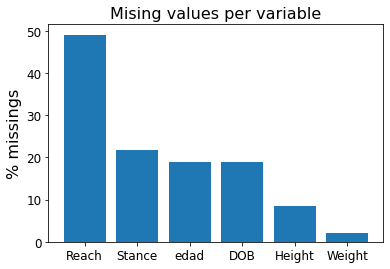

In [150]:
#Representamos un grafico de barras con las variables con mas missings
na_counts = missing_data_table(fighters)
plt.rcParams['font.size'] = 12
plt.figure()
plt.title('Mising values per variable', fontsize = 16)
plt.ylabel('% missings', fontsize = 16)
plt.bar(na_counts.index[:6], na_counts['Percent'][:6]);

* Estudiamos la distribucion y relacion de las variables para determinar si podemos sustituir los missings de algunas variables como 'Reach' o 'Stance' que tienen un gran numero de NAs

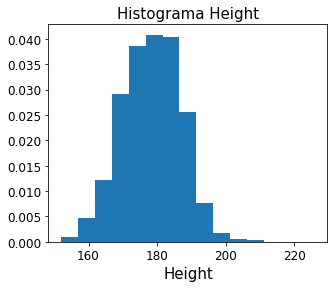

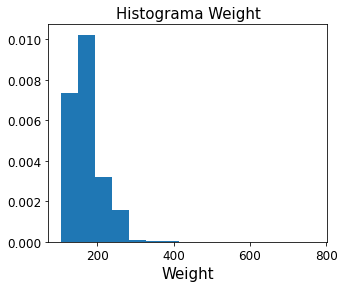

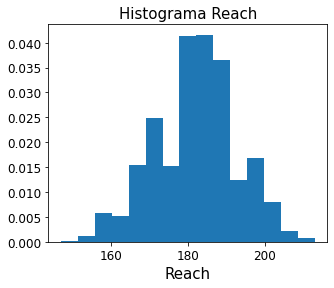

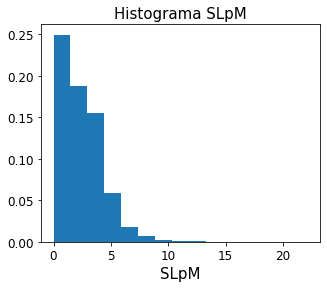

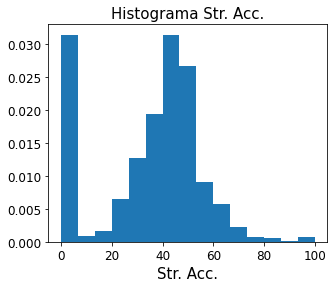

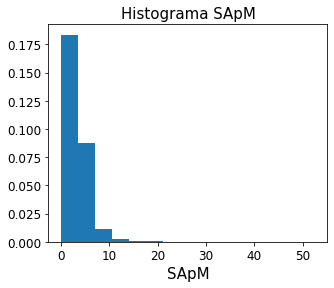

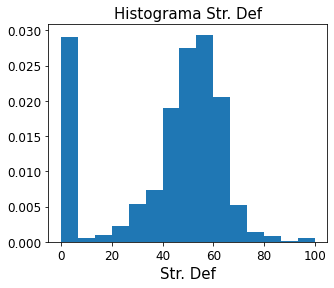

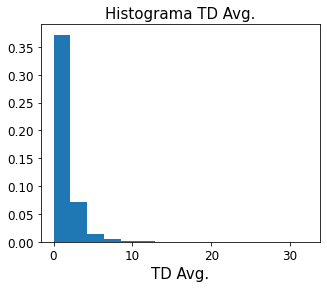

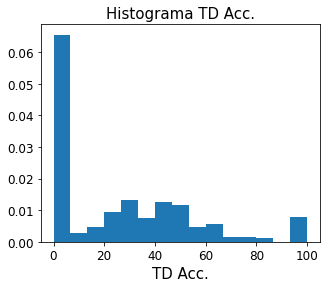

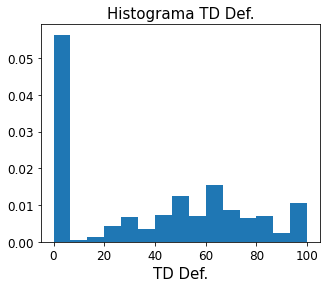

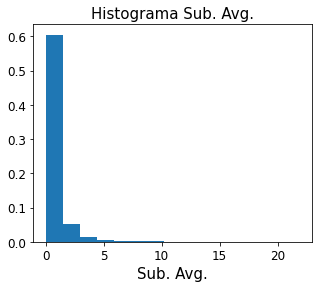

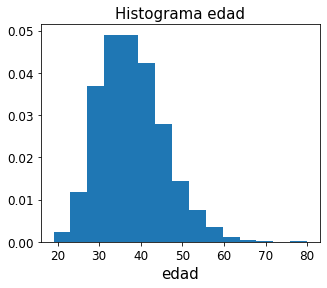

In [151]:
def plot_hist(col, bins = 30, title = '', xlabel = '', fontsize = 15, ax = None, range = None):
    '''
    Funcion para representar un histograma ajustando el formato
    
    col = columna del dataset a representar
    
    '''
    
    ax.set_title(f'Histograma {title}', fontsize = fontsize)
    ax.set_xlabel(xlabel, fontsize = fontsize)
    ax.hist(col, bins = bins, density = True);   

    
#Visualizacion de los histogramas usando la funcion previamente creada    
fighters_stats = ['Height', 'Weight', 'Reach','SLpM', 'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.', 'TD Acc.',
       'TD Def.', 'Sub. Avg.', 'edad']

for stat in fighters_stats:
        
    fig, ax = plt.subplots(figsize = (5,4))
    plot_hist(fighters[stat],
              bins = 15,
             title = f'{stat}',
             xlabel = stat,
             ax = ax)

In [152]:
#Calculo media y mediana edad
mean_edad = fighters['edad'].mean()
median_edad = fighters['edad'].median()

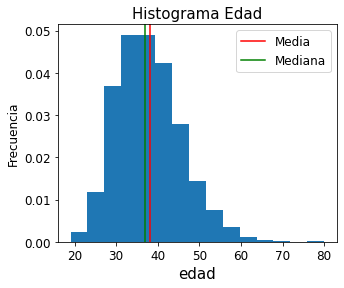

In [153]:
#Histograma Edad
fig, ax = plt.subplots(figsize = (5,4))
plot_hist(fighters['edad'],
        bins = 15,
        title = 'Edad',
        xlabel = stat,
        ax = ax)
plt.axvline(mean_edad, color = 'red', label = 'Media')
plt.axvline(median_edad, color = 'green', label = 'Mediana')
plt.ylabel('Frecuencia')
plt.legend();

In [154]:
#Calculo media y mediana altura
mean_edad = fighters['Height'].mean()
median_edad = fighters['Height'].median()

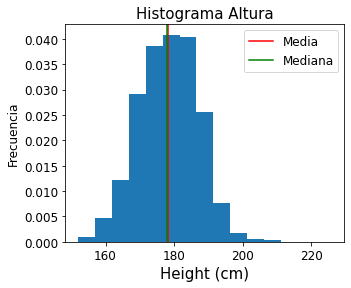

In [155]:
#Histograma Altura
fig, ax = plt.subplots(figsize = (5,4))
plot_hist(fighters['Height'],
        bins = 15,
        title = 'Altura',
        xlabel = 'Height (cm)',
        ax = ax)
plt.axvline(mean_edad, color = 'red', label = 'Media')
plt.axvline(median_edad, color = 'green', label = 'Mediana')
plt.ylabel('Frecuencia')
plt.legend();

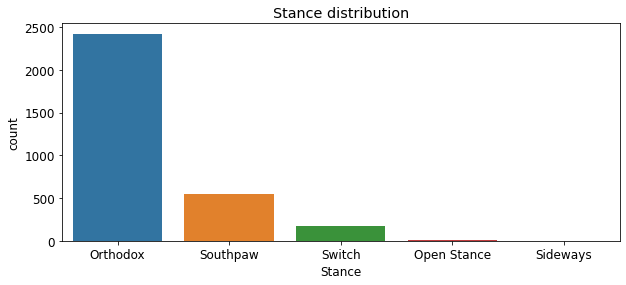

In [156]:
#Countplot de las guardias de los peleadores
fig, ax = plt.subplots(figsize = (10,4))
plt.title('Stance distribution')
plt.xlabel('Stance')
plt.ylabel('Count')
frequencias = fighters['Stance'].value_counts()
sns.countplot(data = fighters, x = 'Stance', order = frequencias.index)
plt.show()

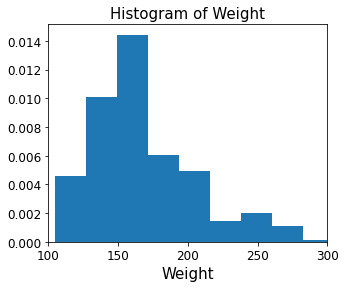

In [157]:
# Peso ajustando los limites quitando valores extremos
fig, ax = plt.subplots(figsize = (5,4))
ax.set_title(f'Histogram of Weight', fontsize = 15)
ax.set_xlabel('Weight', fontsize = 15)
plt.xlim(100,300)
ax.hist(fighters['Weight'], bins = 30, density = True); 


#### Stance
* La mayor parte de los peleadores emplean una guardia ortodoxa 

#### Hegiht y Reach
* A la vista sigue una distribucion normal, se podrian sustituir los NAs por la altura media (otra opcion seria ver la distribucion segun el peso de la division de peso) o ver la relacion entre ambas ya que anatomicamente suelen estar relacionadas

#### Weight
* A la vista sigue una distribucion normal. Con una cola larga en los pesos altos, tiene sentido ya que hay un menor numero de peleadores profesionales Heavyweight

#### Str. Acc, Str. Def,  TD Acc., TD def
* Las variables que representan un porcentaje de precion o golpeo muestran una gran cantidad de valores cercanos a cero



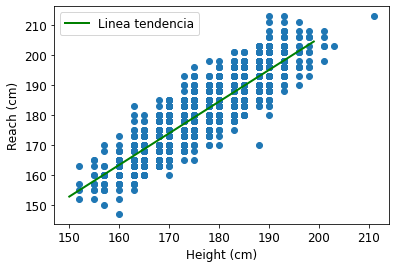

In [158]:
#Scatter plot para ver la relacion entre las variables Height y Fighters
df_NoNas = fighters.dropna().copy()

a, b = np.polyfit(df_NoNas['Height'], df_NoNas['Reach'], 1)
x = range(150, 200, 1)
y = a*x+b
plt.scatter(fighters['Height'], fighters['Reach'])
plt.xlabel('Height (cm)')
plt.ylabel('Reach (cm)')
plt.plot(x, y, 'g', linewidth=2, label = 'Linea tendencia')
plt.legend();

#### Hegiht y Reach
* Confirmamos la teoria de que anatomicamente la altura suele coincidir con la envergadura (Alcance)

In [159]:
#Distrubucion de la variable Altura en relacion a la categoria de peso
divisiones_peso = [0, 115, 125, 135, 145, 155, 170, 185, 205, 265, 1000]
labels = ['0-115', '115-125', '125-135', '135-145', '145-155', '155-170', '170-185', '185-205', '205-265', '+265']
df = fighters[['Height', 'Weight']].copy()
df['categoria'] = pd.cut(df['Weight'], bins=divisiones_peso, labels=labels)

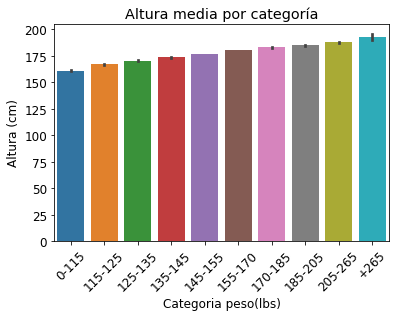

In [160]:
plt.title('Altura media por categoría')
sns.barplot(data = df, x= 'categoria', y= 'Height')
plt.xlabel('Categoria peso(lbs)')
plt.ylabel('Altura (cm)')
plt.xticks(rotation=45);

* Se sustituyen los NAs de altura por la media de su rango de peso, y los de reach por el valor de la altura
* Se sustituyen los NAs de Stance por Orthodox
* Se sustituyen los NAs de la edad por la mediana (se adaptará a la fecha en la que ocurriera la pelea)
* Se eliminan el resto ya que no son un porcentaje considerable de la N total de peleadores

In [161]:
fighters['Stance'] = fighters['Stance'].fillna('Orthodox')

divisiones_peso = [0, 115, 125, 135, 145, 155, 170, 185, 205, 265, 1000]
for i in range(len(divisiones_peso)-1):
    mask = (fighters['Weight']>divisiones_peso[i]) & (fighters['Weight']<=divisiones_peso[i+1])
    media_altura_div = round(fighters[mask]['Height'].mean(), 2)
    fighters.loc[mask, 'Height'] = fighters.loc[mask, 'Height'].fillna(media_altura_div)

fighters.loc[fighters['Reach'].isnull(), 'Reach'] = fighters['Height'].copy()

fighters['edad'] = fighters['edad'].fillna(fighters['edad'].median())

In [162]:
missing_data_table(fighters)

,Total,Percent
DOB,767,19.02
Weight,88,2.18
Reach,82,2.03
Height,82,2.03
Full Name,0,0.00
SApM,0,0.00
Sub. Avg.,0,0.00
TD Def.,0,0.00
TD Acc.,0,0.00
TD Avg.,0,0.00


In [163]:
# Se elimina la variable DOB que no sera necesaria y se eliminan
# el resto de peleas con NAs (aprox 2%)
fighters.drop(['DOB'], axis = 1, inplace = True)
fighters.dropna(inplace = True) 

In [164]:
fighters.shape

(3945, 17)

In [165]:
missing_data_table(fighters)

,Total,Percent
Full Name,0,0.0
Str. Acc.,0,0.0
Sub. Avg.,0,0.0
TD Def.,0,0.0
TD Acc.,0,0.0
TD Avg.,0,0.0
Str. Def,0,0.0
SApM,0,0.0
SLpM,0,0.0
Height,0,0.0


In [166]:
#Se eliminan peleador duplicados en la obtencion de los datos
fighters.drop_duplicates(subset=['Full Name'], inplace = True)

In [167]:
#Guardamos el data set
fighters.to_csv('fighter_stats.csv', index=False)

In [168]:
fighters = pd.read_csv('./fighter_stats.csv')

In [169]:
fighters.head(1)

,Full Name,Height,Weight,Reach,Stance,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad
0,Tom Aaron,176.72,155.0,176.72,Orthodox,5.0,3.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,45.0


# 2. Scraping bouts min
### Pasa al punto 2.1 si quieres replicar el proyecto con el dataset proporcionado en el link de la memoria

* Scraping pagina eventos ufc: http://ufcstats.com/statistics/events/completed

In [43]:
# Obtenemos todos los eventos
bouts_link = 'http://ufcstats.com/statistics/events/completed?page=all'
events_v2 = pd.read_html(bouts_link)[0]

In [44]:
# Se eliminan las filas correspondientes a eventos futuros
events_v2.drop([0,1], inplace=True)
events_v2.reset_index(drop=True, inplace=True)
events_v2.head()

,Name/date,Location
0,"UFC 289: Nunes vs. Aldana June 10, 2023","Vancouver, British Columbia, Canada"
1,UFC Fight Night: Kara-France vs. Albazi June ...,"Las Vegas, Nevada, USA"
2,"UFC Fight Night: Dern vs. Hill May 20, 2023","Las Vegas, Nevada, USA"
3,UFC Fight Night: Rozenstruik vs. Almeida May ...,"Charlotte, North Carolina, USA"
4,"UFC 288: Sterling vs. Cejudo May 06, 2023","Newark, New Jersey, USA"


In [45]:
events_v2.shape

(649, 2)

* Obtenemos los enlaces de cada evento realizado

In [46]:
response = requests.get(bouts_link)
soup = BS(response.text)
scrap_table = soup.find('tbody')
rows = scrap_table.find_all('a')
event_link = []
for row in rows[1:]:
    event = row['href']
    event_link.append(event)
    
    
events_v2['link']= pd.Series(event_link)

In [47]:
events_v2.head()

,Name/date,Location,link
0,"UFC 289: Nunes vs. Aldana June 10, 2023","Vancouver, British Columbia, Canada",http://ufcstats.com/event-details/b6c6d1731ff0...
1,UFC Fight Night: Kara-France vs. Albazi June ...,"Las Vegas, Nevada, USA",http://ufcstats.com/event-details/7abe471b6172...
2,"UFC Fight Night: Dern vs. Hill May 20, 2023","Las Vegas, Nevada, USA",http://ufcstats.com/event-details/6f812143641c...
3,UFC Fight Night: Rozenstruik vs. Almeida May ...,"Charlotte, North Carolina, USA",http://ufcstats.com/event-details/901cddcbfa07...
4,"UFC 288: Sterling vs. Cejudo May 06, 2023","Newark, New Jersey, USA",http://ufcstats.com/event-details/3c6976f8182d...


* Obtenemos los datos da cada una de las peleas de cada evento usando el link previamente extraido

In [48]:
peleas_por_evento = []
for i in range(len(events_v2['link'])):
    response = requests.get(events_v2['link'][i])
    soup = BS(response.text)
    links_peleas = pd.Series([tr['data-link'] for tr in soup.find_all('tr')[1:]], name = 'link')
    fights = pd.read_html(events_v2['link'][i])[0]
    fecha = pd.Series(np.full(len(links_peleas), events_v2['Name/date'][i]), name = 'date_fight')
    fights_with_link = pd.concat([fights,fecha, links_peleas], axis = 1)
    peleas_por_evento.append(fights_with_link)
    time.sleep(1) # Evita bloqueo del servidor
    
bouts = pd.concat(peleas_por_evento, axis=0)
bouts.reset_index(drop=True, inplace=True)

#Guardamos los datos obtenidos del scraping
bouts.to_csv('bouts_min_inicial.csv', index = False)
bouts.head()

,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,date_fight,link
0,win,Amanda Nunes Irene Aldana,0 0,142 41,6 0,0 0,Women's Bantamweight,U-DEC,5,5:00,"UFC 289: Nunes vs. Aldana June 10, 2023",http://ufcstats.com/fight-details/69bc7ca8ce83...
1,win,Charles Oliveira Beneil Dariush,1 0,26 12,0 0,0 0,Lightweight,KO/TKO Punches,1,4:10,"UFC 289: Nunes vs. Aldana June 10, 2023",http://ufcstats.com/fight-details/40e8bf8ce508...
2,win,Mike Malott Adam Fugitt,1 0,19 9,2 0,1 0,Welterweight,SUB Guillotine Choke,2,1:06,"UFC 289: Nunes vs. Aldana June 10, 2023",http://ufcstats.com/fight-details/e9d5ffcacf7d...
3,win,Dan Ige Nate Landwehr,1 0,88 74,0 0,0 0,Featherweight,U-DEC,3,5:00,"UFC 289: Nunes vs. Aldana June 10, 2023",http://ufcstats.com/fight-details/46c67efd68a0...
4,win,Marc-Andre Barriault Eryk Anders,1 0,95 83,0 1,0 0,Middleweight,U-DEC,3,5:00,"UFC 289: Nunes vs. Aldana June 10, 2023",http://ufcstats.com/fight-details/5311298f7941...


## 2.1. Limpieza dataset bouts
## Comenzar desde aquí si usaras el dataset proporcionado

In [170]:
bouts = pd.read_csv('./bouts_min_inicial.csv')

* Siempre aparece como ganado el primer peleador, eliminamos empates y nulos por ser muy pocos casos

In [171]:
bouts['W/L'].unique()

array(['win', 'nc  nc', 'draw  draw'], dtype=object)

In [172]:
mask = bouts['W/L'] != 'win'
index = bouts[mask].index
bouts.drop(index, inplace = True)

In [173]:
bouts['W/L'].unique()

array(['win'], dtype=object)

In [174]:
bouts.shape

(7039, 12)

In [175]:
bouts.to_csv('bouts_min.csv', index=False)

In [176]:
bouts = pd.read_csv('./bouts_min.csv')

In [177]:
# Fucnion para extraer el ganador
def winner(fighters):
    '''
    fighter: str de los dos peleadores separados por dos espacios
    
    Se devuelve el primero que es siempre el ganador
    '''
    separed = str(fighters).split('  ')
    winner = separed[0]
    return winner

In [178]:
#Dividimos las columnas en Peleador_0 y sus estadisiticas y Peleador_1 y sus estadisticas

cols_dividir = ['Fighter', 'Kd', 'Str', 'Td', 'Sub']

bouts_chunks = pd.read_csv('./bouts_min.csv', chunksize = 20)
bouts_dfs = []
for chunk in bouts_chunks:
    chunk.drop(['W/L'], axis = 1, inplace = True)
    chunk['winner_name'] = chunk['Fighter'].apply(winner)
    rand0 = np.random.choice([0,1])
    rand1 = 0 if rand0 == 1 else 1
    for col in cols_dividir:
        new = chunk[col].str.split('  ', expand = True)
        col0 = str(col)+ '_0'
        col1 = str(col)+ '_1'
        chunk[col0] = new[rand0].copy()
        chunk[col1] = new[rand1].copy()
        chunk.drop(col, axis = 1, inplace = True)
    bouts_dfs.append(chunk)

bouts = pd.concat(bouts_dfs, ignore_index = True)

In [179]:
bouts.head()

,Weight class,Method,Round,Time,date_fight,link,winner_name,Fighter_0,Fighter_1,Kd_0,Kd_1,Str_0,Str_1,Td_0,Td_1,Sub_0,Sub_1
0,Women's Bantamweight,U-DEC,5,5:00,"UFC 289: Nunes vs. Aldana June 10, 2023",http://ufcstats.com/fight-details/69bc7ca8ce83...,Amanda Nunes,Amanda Nunes,Irene Aldana,0,0,142,41,6,0,0,0
1,Lightweight,KO/TKO Punches,1,4:10,"UFC 289: Nunes vs. Aldana June 10, 2023",http://ufcstats.com/fight-details/40e8bf8ce508...,Charles Oliveira,Charles Oliveira,Beneil Dariush,1,0,26,12,0,0,0,0
2,Welterweight,SUB Guillotine Choke,2,1:06,"UFC 289: Nunes vs. Aldana June 10, 2023",http://ufcstats.com/fight-details/e9d5ffcacf7d...,Mike Malott,Mike Malott,Adam Fugitt,1,0,19,9,2,0,1,0
3,Featherweight,U-DEC,3,5:00,"UFC 289: Nunes vs. Aldana June 10, 2023",http://ufcstats.com/fight-details/46c67efd68a0...,Dan Ige,Dan Ige,Nate Landwehr,1,0,88,74,0,0,0,0
4,Middleweight,U-DEC,3,5:00,"UFC 289: Nunes vs. Aldana June 10, 2023",http://ufcstats.com/fight-details/5311298f7941...,Marc-Andre Barriault,Marc-Andre Barriault,Eryk Anders,1,0,95,83,0,1,0,0


In [180]:
# Funcion para obtener la fecha del nombre del evento
def date_list(list_):
    '''
    Lista de las palabras del nombre del evento
    Devuelve la fecha en formato str separada por espacios:
    
    Mes nombre
    Dia
    Año completo
    '''
    date = list_[-3]+' '+list_[-2]+' '+list_[-1]
    return date

In [181]:
#Ajuste del formato de la fecha
bouts['date_fight'] = bouts['date_fight'].str.replace(',', '').str.split(' ')
bouts['date_fight']= bouts['date_fight'].apply(date_list)
bouts.head(3)

,Weight class,Method,Round,Time,date_fight,link,winner_name,Fighter_0,Fighter_1,Kd_0,Kd_1,Str_0,Str_1,Td_0,Td_1,Sub_0,Sub_1
0,Women's Bantamweight,U-DEC,5,5:00,June 10 2023,http://ufcstats.com/fight-details/69bc7ca8ce83...,Amanda Nunes,Amanda Nunes,Irene Aldana,0,0,142,41,6,0,0,0
1,Lightweight,KO/TKO Punches,1,4:10,June 10 2023,http://ufcstats.com/fight-details/40e8bf8ce508...,Charles Oliveira,Charles Oliveira,Beneil Dariush,1,0,26,12,0,0,0,0
2,Welterweight,SUB Guillotine Choke,2,1:06,June 10 2023,http://ufcstats.com/fight-details/e9d5ffcacf7d...,Mike Malott,Mike Malott,Adam Fugitt,1,0,19,9,2,0,1,0


* Seleccionamos las variables que nos seran de utilidad para combinar posteriormente los dos dataset
* Las variables no descritas (Kd, Str, Td, Sub) son estadisticas obtenidas tras la pelea no podremos usarlas como predictivas ya que se conocen a posteriori

In [182]:
#Codificamos el ganador como 0 o 1
bouts_min = bouts[['Fighter_0', 'Fighter_1', 'date_fight', 'winner_name']].copy()
bouts_min['winner'] = np.where(bouts_min['Fighter_0'] == bouts_min['winner_name'], 0, 1)
bouts_min.sample(5)

,Fighter_0,Fighter_1,date_fight,winner_name,winner
4855,Marcelo Guimaraes,Hyun Gyu Lim,March 02 2013,Hyun Gyu Lim,1
1923,Jorge Masvidal,Ben Askren,July 06 2019,Jorge Masvidal,0
5122,Kyle Kingsbury,Glover Teixeira,May 26 2012,Glover Teixeira,1
4491,Renan Barao,Urijah Faber,February 01 2014,Renan Barao,0
6729,Kelly Dullanty,Matt Serra,March 22 2002,Matt Serra,1


In [183]:
bouts_min.shape

(7039, 5)

In [184]:
# Eliminamos posibles duplicados
bouts_min.drop_duplicates(subset = ['Fighter_0',  'date_fight'], inplace = True, keep = False)
bouts_min.drop_duplicates(subset = ['Fighter_1',  'date_fight'], inplace = True, keep = False)
bouts_min.shape

(6962, 5)

In [185]:
#unimos los datasets bouts y fighters
bouts_fighter_stats = bouts_min.merge(fighters, how = 'inner', left_on = 'Fighter_0', right_on = 'Full Name')
bouts_fighter_stats = bouts_fighter_stats.merge(fighters, 
                                                how = 'inner', 
                                                left_on = 'Fighter_1', 
                                                right_on = 'Full Name', 
                                                suffixes = ['_0', '_1'])
#eliminamos posibles duplicados
bouts_fighter_stats.drop_duplicates(inplace=True)
bouts_fighter_stats.to_csv('./dataset_vmin.csv', index = False)

In [186]:
bouts_fighter_stats.shape

(6920, 39)

In [187]:
bouts_fighter_stats.head()

,Fighter_0,Fighter_1,date_fight,winner_name,winner,Full Name_0,Height_0,Weight_0,Reach_0,Stance_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,edad_0,Full Name_1,Height_1,Weight_1,Reach_1,Stance_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_1
0,Amanda Nunes,Irene Aldana,June 10 2023,Amanda Nunes,0,Amanda Nunes,173.0,135.0,175.0,Orthodox,23.0,5.0,0.0,4.55,51,2.62,57,2.73,54,82,0.7,35.0,Irene Aldana,175.0,135.0,173.0,Orthodox,14.0,7.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0
1,Holly Holm,Irene Aldana,October 03 2020,Holly Holm,0,Holly Holm,173.0,135.0,175.0,Southpaw,15.0,6.0,0.0,3.17,40,2.77,56,0.92,31,78,0.1,42.0,Irene Aldana,175.0,135.0,173.0,Orthodox,14.0,7.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0
2,Ketlen Vieira,Irene Aldana,December 14 2019,Irene Aldana,1,Ketlen Vieira,173.0,135.0,173.0,Orthodox,13.0,3.0,0.0,3.24,41,4.16,51,1.36,40,92,0.4,32.0,Irene Aldana,175.0,135.0,173.0,Orthodox,14.0,7.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0
3,Katlyn Chookagian,Irene Aldana,April 08 2017,Katlyn Chookagian,0,Katlyn Chookagian,175.0,125.0,173.0,Orthodox,18.0,5.0,0.0,4.59,34,4.41,63,0.27,15,54,0.3,35.0,Irene Aldana,175.0,135.0,173.0,Orthodox,14.0,7.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0
4,Macy Chiasson,Irene Aldana,September 10 2022,Irene Aldana,1,Macy Chiasson,180.0,135.0,183.0,Orthodox,9.0,3.0,0.0,3.64,44,2.61,46,2.17,34,64,0.3,32.0,Irene Aldana,175.0,135.0,173.0,Orthodox,14.0,7.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0


In [188]:
bouts_fighter_stats.to_csv('./dataset_vmin.csv', index = False)

In [189]:
df = pd.read_csv('./dataset_vmin.csv')

#### Codifico las variables categoricas usando dummies

In [190]:
dummies_stance = pd.get_dummies(df[['Stance_0', 'Stance_1']], prefix = ['St_0', 'St_1'])
df = pd.concat([df, dummies_stance], axis=1)
df.drop(['Stance_0', 'Stance_1'], axis = 1, inplace = True)
df.head()

,Fighter_0,Fighter_1,date_fight,winner_name,winner,Full Name_0,Height_0,Weight_0,Reach_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,edad_0,Full Name_1,Height_1,Weight_1,Reach_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_1,St_0_Open Stance,St_0_Orthodox,St_0_Sideways,St_0_Southpaw,St_0_Switch,St_1_Open Stance,St_1_Orthodox,St_1_Sideways,St_1_Southpaw,St_1_Switch
0,Amanda Nunes,Irene Aldana,June 10 2023,Amanda Nunes,0,Amanda Nunes,173.0,135.0,175.0,23.0,5.0,0.0,4.55,51,2.62,57,2.73,54,82,0.7,35.0,Irene Aldana,175.0,135.0,173.0,14.0,7.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0,False,True,False,False,False,False,True,False,False,False
1,Holly Holm,Irene Aldana,October 03 2020,Holly Holm,0,Holly Holm,173.0,135.0,175.0,15.0,6.0,0.0,3.17,40,2.77,56,0.92,31,78,0.1,42.0,Irene Aldana,175.0,135.0,173.0,14.0,7.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0,False,False,False,True,False,False,True,False,False,False
2,Ketlen Vieira,Irene Aldana,December 14 2019,Irene Aldana,1,Ketlen Vieira,173.0,135.0,173.0,13.0,3.0,0.0,3.24,41,4.16,51,1.36,40,92,0.4,32.0,Irene Aldana,175.0,135.0,173.0,14.0,7.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0,False,True,False,False,False,False,True,False,False,False
3,Katlyn Chookagian,Irene Aldana,April 08 2017,Katlyn Chookagian,0,Katlyn Chookagian,175.0,125.0,173.0,18.0,5.0,0.0,4.59,34,4.41,63,0.27,15,54,0.3,35.0,Irene Aldana,175.0,135.0,173.0,14.0,7.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0,False,True,False,False,False,False,True,False,False,False
4,Macy Chiasson,Irene Aldana,September 10 2022,Irene Aldana,1,Macy Chiasson,180.0,135.0,183.0,9.0,3.0,0.0,3.64,44,2.61,46,2.17,34,64,0.3,32.0,Irene Aldana,175.0,135.0,173.0,14.0,7.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0,False,True,False,False,False,False,True,False,False,False


In [191]:
#Funcion para calcular la racha del peleador
def racha(col_peleador, col_ganador):
    '''
    Se compara el nombre del ganador y el del ganandor del dataset historico de peleas
    que se creará (previamente ordenado por fecha)
    
    valores negativos representan racha derrotas de X peleas
    valores positivos representan racha vitorias de X peleas
    
    '''
    col_rachas = [0]
    racha = 0
    for i in range(1,len(col_peleador)):
        if col_peleador[i-1] == col_ganador[i-1]:
            if col_rachas[i-1] > 0:
                racha += 1
                col_rachas.append(racha)
            else:
                racha = 1
                col_rachas.append(racha)
                
        if col_peleador[i-1] != col_ganador[i-1]:
            if col_rachas[i-1] < 0:
                racha -= 1
                col_rachas.append(racha)
            else:
                racha = -1
                col_rachas.append(racha)
    
    return col_rachas

#funcion para el calculo de la racha actual para frontend prediccion
def actual_racha(peleador, ganador, racha):
    if racha <= 0:
        if peleador == ganador:
            racha_actual = 1
        else:
            racha_actual = racha -1
    else:
        if peleador == ganador:
            racha_actual = racha + 1
        else:
            racha_actual = -1
    return racha_actual

#Funcion para calular las vicorias y derrotas
def victorias_derrotas(fighter, winner_name):
    '''
    Devuelve una lista desi ha ganado o perdido
    Se usa asi parar despues calcular las victorias y derrotas acumuladas hasta la fecha de la pelea
    y actualizar el record de victorias
    '''
    if str(fighter) == str(winner_name):
        w = 1
        l = 0
    else:
        w = 0
        l = 1
    return [w, l]

#Funcion para actualizar el record en base al resultado obtenido en la anterior funcion
def act_record(w, l, cumW, cumL):
    if w != 0:
        w -= cumW
    if l != 0:
        l -= cumL
    return [w, l]

In [192]:
#Comprobación final de los duplicados 
df = df.drop_duplicates(subset=['Fighter_0', 'Fighter_1', 'date_fight'])

In [193]:
df.shape

(6920, 47)

* Creacion de nuevas variables y actualizacion del record profesional

In [194]:
#Creacion del dataset del historico de peleas de cada peleador
#para actualizacion de las variables W, L, edad, ufc_bouts y racha
list_peleadores = list(set(df['Fighter_0']) | set(df['Fighter_1']))

now = datetime.now()

#lista para creacion posterior del dataset con las estadisticas mas recientes para el frontend
stats_finales_peleadores = []

#lista para creacion posterior del dataset con el historico de peleas con estadisticas actualizadas
stats_finales_peleas = []

cols = df.columns
cols0 = [col for col in cols if col.find('0')>=1]
cols1 = [col for col in cols if col.find('1')>=1]
cols0.extend(['date_fight', 'winner_name'])
cols1.extend(['date_fight', 'winner_name'])

colsmerg = [col.replace('_0','') for col in cols0]
colsmerg[0] = 'Name'

for peleador in list_peleadores:
    
    ## Combinar peleas 'local' y 'visitante' para calculo estadisitcas por pelea
    df0 = df[df['Fighter_0']==peleador]
    df0 = df0[cols0]
    df0.columns = colsmerg
    df1 = df[df['Fighter_1']==peleador]
    df1 = df1[cols1]
    df1.columns = colsmerg
    df_peleador = pd.concat([df0, df1])
    df_peleador['date_fight'] = pd.to_datetime(df['date_fight'])
    df_peleador.drop(['Full Name'], axis=1, inplace=True) 
    df_peleador.sort_values(by = 'date_fight', ascending=True, inplace=True)
    
    #variable provisional nº peleas en ufc
    df_peleador['ufc_bouts'] = range(0,len(df_peleador['Name']), 1)
    
    #calculo racha
    df_peleador['racha'] = racha(df_peleador['Name'].values, df_peleador['winner_name'].values)
    
    df_peleador.sort_values(by = 'date_fight', ascending=False, inplace=True)
    
    #Calculo de Wins y Losses
    df_peleador['W,L'] = df_peleador.apply(lambda x: victorias_derrotas(x['Name'], x['winner_name']), axis = 1)
    df_peleador['cum_W'] = df_peleador['W,L'].apply(lambda x: x[0])
    df_peleador['cum_L'] = df_peleador['W,L'].apply(lambda x: x[1])

    for record in ['cum_W', 'cum_L']:
        df_peleador[record] = np.array(df_peleador[record]).cumsum()    
    
    df_peleador['W,L'] = df_peleador.apply(lambda x: act_record(x['W'], x['L'], x['cum_W'], x['cum_L']), axis = 1)
    df_peleador['W'] = df_peleador['W,L'].apply(lambda x: x[0])
    df_peleador['L'] = df_peleador['W,L'].apply(lambda x: x[1])
    
    df_peleador.drop(['W,L', 'cum_W', 'cum_L'], axis=1, inplace=True)
    
    df_peleador_pred = df_peleador.head(1).copy()
    df_peleador_pred['ufc_bouts'] = df_peleador_pred['ufc_bouts'] +1
    df_peleador_pred['racha'] = actual_racha(df_peleador_pred['Name'].values, 
                                         df_peleador_pred['winner_name'].values, 
                                         df_peleador_pred['racha'].values)
    
    #Añadmos los datos del peleador de esta iteracion del bucle
    stats_finales_peleadores.append(df_peleador_pred)
    
    df_peleador['today'] = np.full(len(df_peleador['date_fight']), now, dtype='datetime64[ns]')
    df_peleador['años_pasados'] = df_peleador['today'].dt.year - df_peleador['date_fight'].dt.year
    df_peleador['edad'] = df_peleador['edad'] - df_peleador['años_pasados']
    
    df_peleador.drop(['today', 'años_pasados'], axis=1, inplace=True)
    
    stats_finales_peleas.append(df_peleador)

In [195]:
# Ejemplo del formato del dataset historico con el ultimo peleador
# permite actualizar las estadisticas calculadas
df_peleador

,Name,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch,date_fight,winner_name,ufc_bouts,racha
3462,Dequan Townsend,190.0,205.0,201.0,21.0,11.0,0.0,1.23,34,3.92,38,0.0,0,46,0.0,34.0,False,True,False,False,False,2020-10-03,Dusko Todorovic,3,-3
1117,Dequan Townsend,190.0,205.0,201.0,21.0,10.0,0.0,1.23,34,3.92,38,0.0,0,46,0.0,34.0,False,True,False,False,False,2020-02-15,Devin Clark,2,-2
3463,Dequan Townsend,190.0,205.0,201.0,21.0,9.0,0.0,1.23,34,3.92,38,0.0,0,46,0.0,34.0,False,True,False,False,False,2020-01-25,Bevon Lewis,1,-1
3461,Dequan Townsend,190.0,205.0,201.0,21.0,8.0,0.0,1.23,34,3.92,38,0.0,0,46,0.0,33.0,False,True,False,False,False,2019-06-29,Dalcha Lungiambula,0,0


In [196]:
# Ejemplo del formato del dataset de prediccion con el ultimo peleador
# permite actualizar las estadisticas calculadas
df_peleador_pred

,Name,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch,date_fight,winner_name,ufc_bouts,racha
3462,Dequan Townsend,190.0,205.0,201.0,21.0,11.0,0.0,1.23,34,3.92,38,0.0,0,46,0.0,37.0,False,True,False,False,False,2020-10-03,Dusko Todorovic,4,-4


In [197]:
#Dataset historico peleas
df_historial_stats = pd.concat(stats_finales_peleas)
cols = ['Name', 'date_fight', 'Height', 'Weight', 'Reach', 'W', 'L', 'D', 'SLpM', 'Str. Acc.', 'SApM',
       'Str. Def', 'TD Avg.', 'TD Acc.', 'TD Def.', 'Sub. Avg.', 'edad', 'ufc_bouts', 'racha',
       'St_Open Stance', 'St_Orthodox', 'St_Sideways', 'St_Southpaw',
       'St_Switch', 'winner_name']

df_historial_stats = df_historial_stats[cols]

df_historial_stats.sample(10)

,Name,date_fight,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,ufc_bouts,racha,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch,winner_name
5305,Jorge Rivera,2004-10-22,185.0,185.0,185.0,13.0,3.0,0.0,3.16,48,2.64,54,0.84,50,63,0.1,32.0,2,-1,False,True,False,False,False,Rich Franklin
746,Cody Stamann,2018-09-08,168.0,135.0,163.0,17.0,1.0,1.0,4.39,47,3.63,62,2.34,39,76,0.0,29.0,3,3,False,True,False,False,False,Aljamain Sterling
5820,Martin Svensson,2016-02-27,185.0,155.0,185.0,15.0,5.0,0.0,2.02,38,5.91,38,0.00,0,0,0.0,31.0,0,0,False,True,False,False,False,David Teymur
5185,Jared Rosholt,2016-02-06,188.0,265.0,190.0,14.0,3.0,0.0,2.08,46,1.52,59,1.83,41,66,0.1,30.0,7,3,False,True,False,False,False,Roy Nelson
2162,Abdul Razak Alhassan,2017-05-28,178.0,185.0,185.0,7.0,0.0,0.0,3.54,48,4.02,55,0.97,38,52,0.0,32.0,1,1,False,True,False,False,False,Omari Akhmedov
6512,Jon Madsen,2010-07-03,183.0,240.0,183.0,6.0,1.0,0.0,2.46,41,1.18,81,1.32,71,70,0.0,30.0,2,2,False,True,False,False,False,Jon Madsen
5638,Thiago Alves,2006-12-30,175.0,170.0,178.0,11.0,5.0,0.0,3.73,41,3.42,62,0.71,60,63,0.3,23.0,5,1,False,True,False,False,False,Thiago Alves
2592,Alan Jouban,2019-04-13,183.0,170.0,185.0,16.0,6.0,0.0,5.67,50,3.77,60,0.51,44,58,0.3,38.0,11,1,False,False,False,True,False,Dwight Grant
6071,Ednaldo Oliveira,2013-08-03,196.0,205.0,196.0,17.0,2.0,1.0,1.03,22,1.80,52,0.00,0,42,0.0,29.0,1,-1,False,True,False,False,False,Francimar Barroso
993,Ovince Saint Preux,2019-09-28,190.0,205.0,203.0,23.0,13.0,0.0,2.71,47,3.14,46,1.15,38,66,0.5,36.0,19,-2,False,False,False,True,False,Ovince Saint Preux


In [198]:
df_historial_stats.shape

(13840, 25)

In [199]:
#Guardamos el dataset
df_historial_stats.to_csv('historico_stats_peleadores_230205.csv', index=False)

In [200]:
#Dataset predicción
df_pred = pd.concat(stats_finales_peleadores)
cols = ['Name', 'Height', 'Weight', 'Reach', 'W', 'L', 'D', 'SLpM', 'Str. Acc.', 'SApM',
       'Str. Def', 'TD Avg.', 'TD Acc.', 'TD Def.', 'Sub. Avg.', 'edad', 'ufc_bouts', 'racha',
       'St_Open Stance', 'St_Orthodox', 'St_Sideways', 'St_Southpaw',
       'St_Switch']
df_pred = df_pred[cols]
df_pred.sample(10)

,Name,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,ufc_bouts,racha,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch
5625,Gil Castillo,175.0,170.0,175.0,8.0,4.0,0.0,0.60,45,2.22,44,3.33,45,50,0.0,58.0,3,-1,False,False,False,True,False
6784,David Lee,178.0,155.0,178.0,12.0,9.0,0.0,1.49,50,3.31,42,0.00,0,50,0.0,37.0,2,-2,False,True,False,False,False
2651,Maki Pitolo,178.0,185.0,190.0,13.0,8.0,0.0,4.10,44,3.93,55,2.24,52,50,0.8,33.0,6,-4,False,True,False,False,False
6332,Junie Browning,175.0,155.0,175.0,5.0,5.0,0.0,3.76,48,1.76,66,3.53,66,0,3.5,39.0,2,-1,False,True,False,False,False
210,Yohan Lainesse,185.0,170.0,193.0,9.0,1.0,0.0,2.34,42,3.44,59,1.00,28,80,0.5,31.0,3,-1,False,True,False,False,False
5758,Chris Tuchscherer,188.0,258.0,193.0,21.0,3.0,0.0,1.35,31,3.17,47,1.19,18,0,0.6,48.0,4,-2,False,True,False,False,False
4246,Mirsad Bektic,173.0,145.0,178.0,13.0,3.0,0.0,2.43,41,1.80,57,3.98,52,92,0.4,32.0,10,-3,False,True,False,False,False
4685,Youssef Zalal,178.0,135.0,183.0,10.0,4.0,1.0,2.75,48,1.75,64,2.14,31,60,1.1,27.0,6,-3,False,False,False,False,True
5336,Kris McCray,183.0,170.0,193.0,8.0,4.0,0.0,2.69,45,2.57,54,2.88,55,38,0.0,42.0,3,-3,False,True,False,False,False
3799,Austin Springer,173.0,145.0,180.0,12.0,3.0,0.0,3.54,57,3.15,41,3.37,40,100,0.8,36.0,1,-1,False,True,False,False,False


In [201]:
df_pred.to_csv('df_prediccion_230207.csv', index=False)

In [202]:
# Ajuste del formato de la fecha del dataframe original para
# hacer el merge con el historico de peleas y asi devolver los datos a su estructura anterior
df['date_fight'] = pd.to_datetime(df['date_fight'])
df_final = df[['Fighter_0', 'Fighter_1', 'date_fight', 'winner_name', 'winner']].copy()
df_final.shape

(6920, 5)

In [203]:
df_historial_stats.head()

,Name,date_fight,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,ufc_bouts,racha,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch,winner_name
851,Derek Brunson,2023-03-04,185.0,185.0,196.0,23.0,8.0,0.0,3.51,47,3.05,51,3.14,33,85,0.6,39.0,20,-1,False,False,False,True,False,Dricus Du Plessis
2088,Derek Brunson,2022-02-12,185.0,185.0,196.0,23.0,7.0,0.0,3.51,47,3.05,51,3.14,33,85,0.6,38.0,19,5,False,False,False,True,False,Jared Cannonier
2331,Derek Brunson,2021-09-04,185.0,185.0,196.0,22.0,7.0,0.0,3.51,47,3.05,51,3.14,33,85,0.6,37.0,18,4,False,False,False,True,False,Derek Brunson
2623,Derek Brunson,2021-03-20,185.0,185.0,196.0,21.0,7.0,0.0,3.51,47,3.05,51,3.14,33,85,0.6,37.0,17,3,False,False,False,True,False,Derek Brunson
849,Derek Brunson,2020-08-01,185.0,185.0,196.0,20.0,7.0,0.0,3.51,47,3.05,51,3.14,33,85,0.6,36.0,16,2,False,False,False,True,False,Derek Brunson


In [204]:
df = pd.merge(df_final, df_historial_stats,
                    left_on = ['Fighter_0', 'date_fight', 'winner_name'], 
                    right_on = ['Name', 'date_fight', 'winner_name'], 
                    how = 'inner')

df.drop_duplicates(inplace=True)

df = pd.merge(df, df_historial_stats,
                    left_on = ['Fighter_1', 'date_fight', 'winner_name'], 
                    right_on = ['Name', 'date_fight', 'winner_name'], 
                    how = 'inner', suffixes = ['_0', '_1'])

In [205]:
df.head()

,Fighter_0,Fighter_1,date_fight,winner_name,winner,Name_0,Height_0,Weight_0,Reach_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,edad_0,ufc_bouts_0,racha_0,St_Open Stance_0,St_Orthodox_0,St_Sideways_0,St_Southpaw_0,St_Switch_0,Name_1,Height_1,Weight_1,Reach_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_1,ufc_bouts_1,racha_1,St_Open Stance_1,St_Orthodox_1,St_Sideways_1,St_Southpaw_1,St_Switch_1
0,Amanda Nunes,Irene Aldana,2023-06-10,Amanda Nunes,0,Amanda Nunes,173.0,135.0,175.0,22.0,5.0,0.0,4.55,51,2.62,57,2.73,54,82,0.7,35.0,17,1,False,True,False,False,False,Irene Aldana,175.0,135.0,173.0,14.0,6.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0,11,2,False,True,False,False,False
1,Holly Holm,Irene Aldana,2020-10-03,Holly Holm,0,Holly Holm,173.0,135.0,175.0,13.0,5.0,0.0,3.17,40,2.77,56,0.92,31,78,0.1,39.0,11,1,False,False,False,True,False,Irene Aldana,175.0,135.0,173.0,12.0,5.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,32.0,8,2,False,True,False,False,False
2,Ketlen Vieira,Irene Aldana,2019-12-14,Irene Aldana,1,Ketlen Vieira,173.0,135.0,173.0,10.0,0.0,0.0,3.24,41,4.16,51,1.36,40,92,0.4,28.0,4,4,False,True,False,False,False,Irene Aldana,175.0,135.0,173.0,11.0,5.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,31.0,7,1,False,True,False,False,False
3,Katlyn Chookagian,Irene Aldana,2017-04-08,Katlyn Chookagian,0,Katlyn Chookagian,175.0,125.0,173.0,8.0,1.0,0.0,4.59,34,4.41,63,0.27,15,54,0.3,29.0,2,-1,False,True,False,False,False,Irene Aldana,175.0,135.0,173.0,7.0,3.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,29.0,1,-1,False,True,False,False,False
4,Macy Chiasson,Irene Aldana,2022-09-10,Irene Aldana,1,Macy Chiasson,180.0,135.0,183.0,9.0,2.0,0.0,3.64,44,2.61,46,2.17,34,64,0.3,31.0,8,1,False,True,False,False,False,Irene Aldana,175.0,135.0,173.0,13.0,6.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,34.0,10,1,False,True,False,False,False


### B. Elimino las peleas de los peleadores poco relevantes en la compañia (del_pel)

In [207]:
df_filtered = df[~(df['Fighter_0'].isin(del_pel) | df['Fighter_1'].isin(del_pel))]
df = df_filtered.copy()

In [208]:
# Eliminamos las variables idenificativas de los peleadores
df.drop(['Name_0', 'Name_1','Fighter_0', 'Fighter_1', 'winner_name', 'date_fight'], axis = 1, inplace = True)

In [209]:
df.shape

(5940, 45)

In [210]:
df.head()

,winner,Height_0,Weight_0,Reach_0,W_0,L_0,D_0,SLpM_0,Str. Acc._0,SApM_0,Str. Def_0,TD Avg._0,TD Acc._0,TD Def._0,Sub. Avg._0,edad_0,ufc_bouts_0,racha_0,St_Open Stance_0,St_Orthodox_0,St_Sideways_0,St_Southpaw_0,St_Switch_0,Height_1,Weight_1,Reach_1,W_1,L_1,D_1,SLpM_1,Str. Acc._1,SApM_1,Str. Def_1,TD Avg._1,TD Acc._1,TD Def._1,Sub. Avg._1,edad_1,ufc_bouts_1,racha_1,St_Open Stance_1,St_Orthodox_1,St_Sideways_1,St_Southpaw_1,St_Switch_1
0,0,173.0,135.0,175.0,22.0,5.0,0.0,4.55,51,2.62,57,2.73,54,82,0.7,35.0,17,1,False,True,False,False,False,175.0,135.0,173.0,14.0,6.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,35.0,11,2,False,True,False,False,False
1,0,173.0,135.0,175.0,13.0,5.0,0.0,3.17,40,2.77,56,0.92,31,78,0.1,39.0,11,1,False,False,False,True,False,175.0,135.0,173.0,12.0,5.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,32.0,8,2,False,True,False,False,False
2,1,173.0,135.0,173.0,10.0,0.0,0.0,3.24,41,4.16,51,1.36,40,92,0.4,28.0,4,4,False,True,False,False,False,175.0,135.0,173.0,11.0,5.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,31.0,7,1,False,True,False,False,False
3,0,175.0,125.0,173.0,8.0,1.0,0.0,4.59,34,4.41,63,0.27,15,54,0.3,29.0,2,-1,False,True,False,False,False,175.0,135.0,173.0,7.0,3.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,29.0,1,-1,False,True,False,False,False
4,1,180.0,135.0,183.0,9.0,2.0,0.0,3.64,44,2.61,46,2.17,34,64,0.3,31.0,8,1,False,True,False,False,False,175.0,135.0,173.0,13.0,6.0,0.0,4.86,39,5.71,59,0.17,50,75,0.3,34.0,10,1,False,True,False,False,False


In [211]:
df.dtypes

winner                int64
Height_0            float64
Weight_0            float64
Reach_0             float64
W_0                 float64
L_0                 float64
D_0                 float64
SLpM_0              float64
Str. Acc._0           int64
SApM_0              float64
Str. Def_0            int64
TD Avg._0           float64
TD Acc._0             int64
TD Def._0             int64
Sub. Avg._0         float64
edad_0              float64
ufc_bouts_0           int64
racha_0               int64
St_Open Stance_0       bool
St_Orthodox_0          bool
St_Sideways_0          bool
St_Southpaw_0          bool
St_Switch_0            bool
Height_1            float64
Weight_1            float64
Reach_1             float64
W_1                 float64
L_1                 float64
D_1                 float64
SLpM_1              float64
Str. Acc._1           int64
SApM_1              float64
Str. Def_1            int64
TD Avg._1           float64
TD Acc._1             int64
TD Def._1           

* Para evitar que el orden influya en el resultado de la prediccion se restan las estadisticas de ambos peleadores. Así un resultado negativo favorecera al peleador 1 y el positivo al peleador 0

In [212]:
#Calculo de las diferencias en las estadisticas de ambos peleadores
df.iloc[:,1:] = df.iloc[:,1:].astype(float)

cols = df.columns
cols0 = [col for col in cols if ('0' in col)]
cols1 = [col for col in cols if ('1' in col)]

cols_resta = [col[:-2] for col in cols0]

df_clean = pd.DataFrame()

for i in range(len(cols_resta)):
    df_clean[cols_resta[i]] = df[cols0[i]] - df[cols1[i]]

df_clean['winner'] = df['winner'].copy()

In [213]:
df_clean.shape

(5940, 23)

In [214]:
df_clean.columns

Index(['Height', 'Weight', 'Reach', 'W', 'L', 'D', 'SLpM', 'Str. Acc.', 'SApM',
       'Str. Def', 'TD Avg.', 'TD Acc.', 'TD Def.', 'Sub. Avg.', 'edad',
       'ufc_bouts', 'racha', 'St_Open Stance', 'St_Orthodox', 'St_Sideways',
       'St_Southpaw', 'St_Switch', 'winner'],
      dtype='object')

In [215]:
df_clean.head()

,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,ufc_bouts,racha,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch,winner
0,-2.0,0.0,2.0,8.0,-1.0,0.0,-0.31,12.0,-3.09,-2.0,2.56,4.0,7.0,0.4,0.0,6.0,-1.0,0.0,0.0,0.0,0.0,0.0,0
1,-2.0,0.0,2.0,1.0,0.0,0.0,-1.69,1.0,-2.94,-3.0,0.75,-19.0,3.0,-0.2,7.0,3.0,-1.0,0.0,-1.0,0.0,1.0,0.0,0
2,-2.0,0.0,0.0,-1.0,-5.0,0.0,-1.62,2.0,-1.55,-8.0,1.19,-10.0,17.0,0.1,-3.0,-3.0,3.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,-10.0,0.0,1.0,-2.0,0.0,-0.27,-5.0,-1.30,4.0,0.10,-35.0,-21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5.0,0.0,10.0,-4.0,-4.0,0.0,-1.22,5.0,-3.10,-13.0,2.00,-16.0,-11.0,0.0,-3.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,1


* Hacemos una primera visualizacion de la correlacion entre las variables

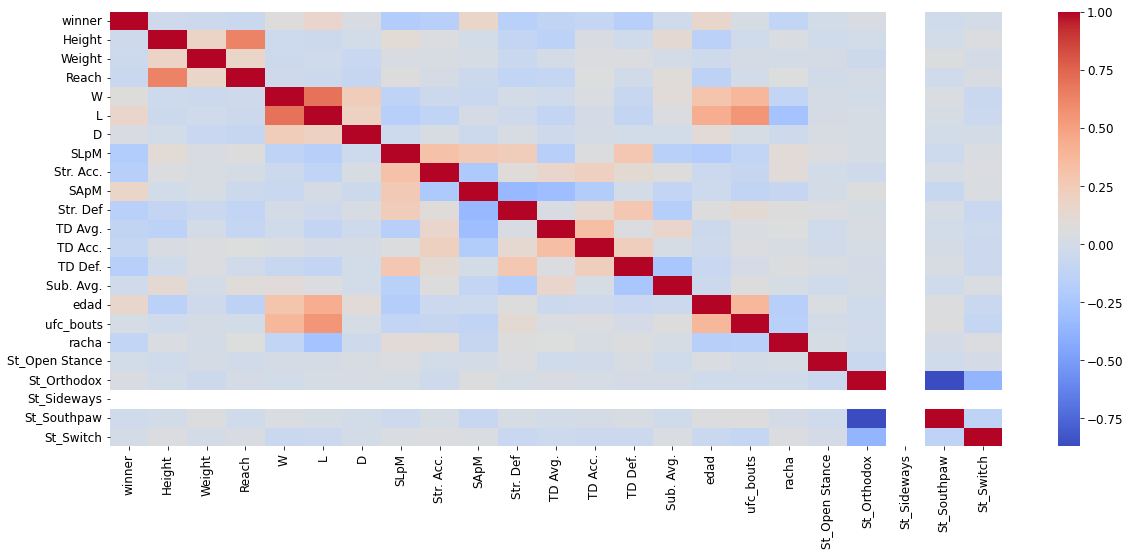

In [216]:
# Matriz de correlacion inicial
df_corr = df_clean[['winner'] + [col for col in df_clean.columns if col != 'winner']]

corr_matrix = df_corr.corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, cmap = 'coolwarm')
plt.show()

In [217]:
corr_matrix['winner'].sort_values(ascending=False)

winner            1.000000
SApM              0.160248
L                 0.159066
edad              0.148779
W                 0.076813
St_Orthodox       0.032815
D                 0.028272
ufc_bouts         0.018862
St_Switch        -0.007460
St_Open Stance   -0.009820
Sub. Avg.        -0.023675
St_Southpaw      -0.030303
Height           -0.035619
Weight           -0.051828
Reach            -0.065680
TD Acc.          -0.094069
racha            -0.104944
TD Avg.          -0.114410
Str. Def         -0.162619
Str. Acc.        -0.174083
TD Def.          -0.175951
SLpM             -0.202537
St_Sideways            NaN
Name: winner, dtype: float64

* Guardamos el dataset con el orden de columnas determinado que se mantendra tambien en el dataset de prediccion del fronten

In [218]:
cols = ['winner', 'Height', 'Weight', 'Reach', 'W', 'L', 'D', 'SLpM', 'Str. Acc.', 'SApM',
       'Str. Def', 'TD Avg.', 'TD Acc.', 'TD Def.', 'Sub. Avg.', 'edad', 'ufc_bouts', 'racha',
       'St_Open Stance', 'St_Orthodox', 'St_Sideways', 'St_Southpaw',
       'St_Switch']

df_clean = df_clean[cols]
df_clean.head(1)

,winner,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,ufc_bouts,racha,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch
0,0,-2.0,0.0,2.0,8.0,-1.0,0.0,-0.31,12.0,-3.09,-2.0,2.56,4.0,7.0,0.4,0.0,6.0,-1.0,0.0,0.0,0.0,0.0,0.0


In [219]:
#Guardamos el modelo para entrenar el modelo
df_clean.to_csv('./df_final_1.csv', index=False)

#### Pasamos a ejecutar el notebook del modelo

# De aquí en adelante se muestra el codigo en sucio de creacion de nuevas estadisticas para discusion del proyecto en la defensa de la memoria

## VERSION 2: Intento de creacion de nuevas estadísticas segun los datos de cada pelea
#### Resultó en un empeoramiento del modelo hasta un 53%. NO se muestran los resultados en el notebook.

# 3. Data cleaning

## Dividir celdas peleadores. BOUTS.CSV

## FIGHTERS.CSV

# 4. Combinacion dataframes bouts y fighters

#### Añadir variable: ufc_bouts: numero de peleas dentro de ufc

* Categorizar el ganador (0 o 1)

* Merge fighters stats (permanentes) y estadisticas bouts

* Calculo edad en la pelea

* Sustituir NAs altura, peso, Reach, edad y stance

**Calculo estadisticas**

* Tiempo

* Finalizaciones variable

* Poner de nuevo el nombre del winner para el calculo posterior de finalizaciones

* Calculo estadisticas acumuladas. Golpes totales, tiempo total etc para calculo de estadisticas globales del peleador en esa fecha
* Calculo finalizaciones peleas y actualizacion victorias derrotas

## Merge con las estadisticas por peleas

* Se eliminan los peleadores duplicados

* Peleadores a eliminar: Bruno Silva, Michael McDonald, Joey Gomez, Mike Davis
* Marcus silveira y kazushi sakuraba tuvieron dos peleas el mismo dia (se duplicaran (dando 4) y habra que eliminarlas)

Hay una pelea menos ya que se elimina una de las peleas de Marcus silveira y kazushi sakuraba que fue el mismo dia

### Stance categorizar